In [1]:
# Code outline:
# 1. Indoor system - data:
#   a. Read data and parameters
#   b. process data (measurements)
# 2. Outdoor system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light HOBO data
# 3. Offshore system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light IMS data
# 4. calculate model results for:
#   a. Indoor system
#   b. Outdoor system
#   c. Offshore system
# 5. calculate errors in the combined df
# df_combined structure:
#System, time, m_exp, m_mod, m_SRE,Nint_exp, Nint_mod, Nint_SRE Next_exp, Next_mod, Next_SRE
# 6... minimize errors?

In [2]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

pandas version is 1.0.1


In [3]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import indoor data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes


In [4]:
# b. process data (indoor measurements)

    # 1. Convert Time into hours
T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

    # 2. Make a temp DF (df2_temp) by filtering the original df - remove 'wierd' results (i.e sporulation) 

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')&(df2.Comment != 'Exclude')]

df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,144.7,5,4,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.426,5.0,...,500.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,501
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,5.0,...,200.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,501


In [5]:
# 4. calculate model results for:
#   a. Indoor system
    # I. Produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment

In [6]:
# parameters for minimum combined error:
miu = 0.04 #0.029
losses20 = 0.004
Nintmax = 4.5 #4.25
Nintcrit = 3.5 #2.9
dNextoutdt = 0.008
Ks = 15.5 #25.8
Vmax = 93.7 #150 #93.7 - high vmax for ammonium
KI = 15.2
K0 = 2.4 #2.1
Ka = 0.12 #0.075
Smin = 2 #2.5 #5
Sopt = 30 #28 #34
Smax = 45
Tmin = 4
Topt = 21.5 #21.9
Tmax = 36.5 #35.9
n = 5.1

In [7]:
miu = 0.04 #0.046
losses20 = 0.004 #0.005
Nintmax = 4.5 #4.25
Nintcrit = 2 #2 #3.7
dNextoutdt = 0.008 #0 #0.04
Ks = 15.5 #25.8 #14 #24.8
Vmax = 93.7 #53 # low because of nitrate
KI = 16 #15.2 #18 #20 #139
K0 = 2.4 #1.5 #1.7
Ka = 0.12 #0.15 #0.127
Smin = 0 #2.5
Sopt = 28 #18
Smax = 45 #45
Topt = 18 #22.2  #21.9 #18
Tmax = 35.9 #34.4
n = 5.1 #2
Tmin = 4

In [8]:
#algorythem based best combination
miu = 0.045 #0.046
losses20 = 0.003 #0.005
Nintmax = 4.3 #4.25
Nintcrit = 1.22 #2 #3.7
dNextoutdt = 0.019 #0 #0.04
Ks = 20.02 #25.8 #14 #24.8
Vmax = 71.289 #53 # low because of nitrate
KI = 22.515 #15.2 #18 #20 #139
K0 = 2.368 #1.5 #1.7
Ka = 0.136 #0.15 #0.127
Smin = 4.912 #2.5
Sopt = 34.473#18
Smax = 41.924 #45
Topt = 19.775 #22.2  #21.9 #18
Tmax = 33.549 #34.4
n = 5.507 #2
Tmin = 5

In [9]:
miu = 0.04 #0.046
losses20 = 0.004 #0.005
Nintmax = 4.5 #4.25
Nintcrit = 2 #2 #3.7
dNextoutdt = 0.008 #0 #0.04
Ks = 15.5 #25.8 #14 #24.8
Vmax = 93.7 #53 # low because of nitrate
KI = 16 #15.2 #18 #20 #139
K0 = 2.4 #1.5 #1.7
Ka = 0.12 #0.15 #0.127
Smin = 0 #2.5
Sopt = 28 #18
Smax = 45 #45
Topt = 18 #22.2  #21.9 #18
Tmax = 35.9 #34.4
n = 5.1 #2
Tmin = 4

In [10]:
miu = 0.03
#miu = X[0]
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 2.3 #2
dNextoutdt = 0.015 #0.01
Ks = 23 #15.5
Vmax = 60 # 50
KI = 16
K0 = 2# 2.4
Ka = 0.1 #0.085 #0.07 #0.12
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1


Treatment: 1000/1/168
Number of samples:
m: 27 Nint: 19 Next: 26
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration

Treatment: 500/2/168
Number of samples:
m: 66 Nint: 37 Next: 90
3.5
0.0
Starting point
84.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
252.0
Period
336.0
Duration
420.0
Period

Treatment: 500/3/168
Number of samples:
m: 18 Nint: 12 Next: 18
2.3333333333333335
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


56.0
Period
112.0
Period
168.0
Duration
224.0
Period
280.0
Period
336.0
Duration
392.0
Period
448.0
Period

Treatment: 2000/1/168
Number of samples:
m: 0 Nint: 0 Next: 0
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration

Treatment: 200/5/168
Number of samples:
m: 0 Nint: 0 Next: 0
1.4
0.0
Starting point
34.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


68.0
Period
102.0
Period
136.0
Period
170.0
Duration
204.0
Period
238.0
Period
272.0
Period
306.0
Period
340.0
Duration
374.0
Period
408.0
Period
442.0
Period
476.0
Period


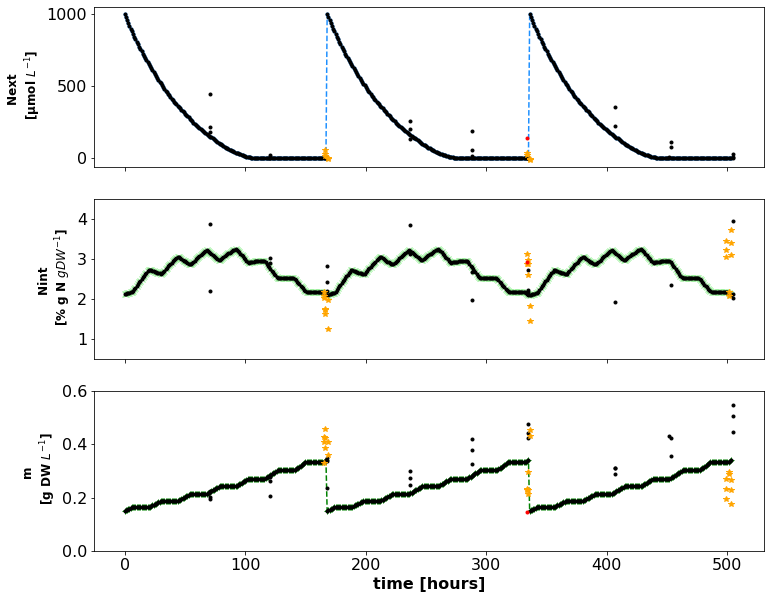

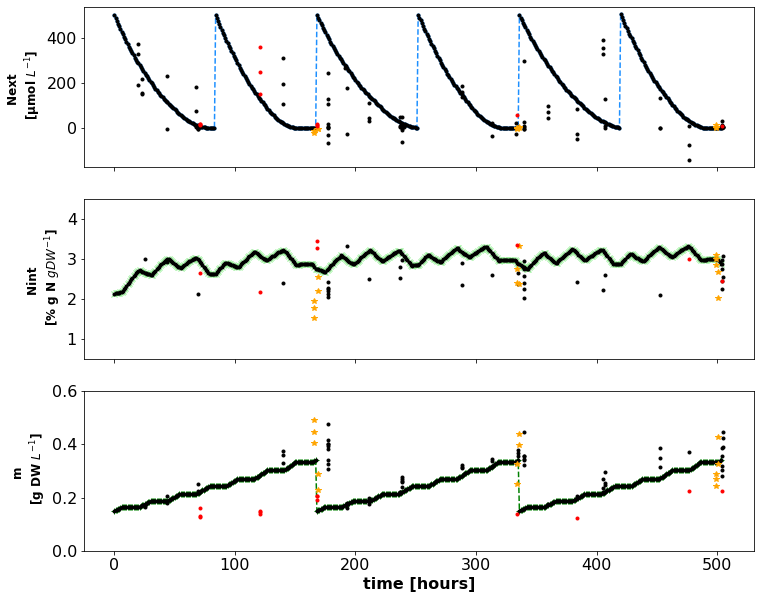

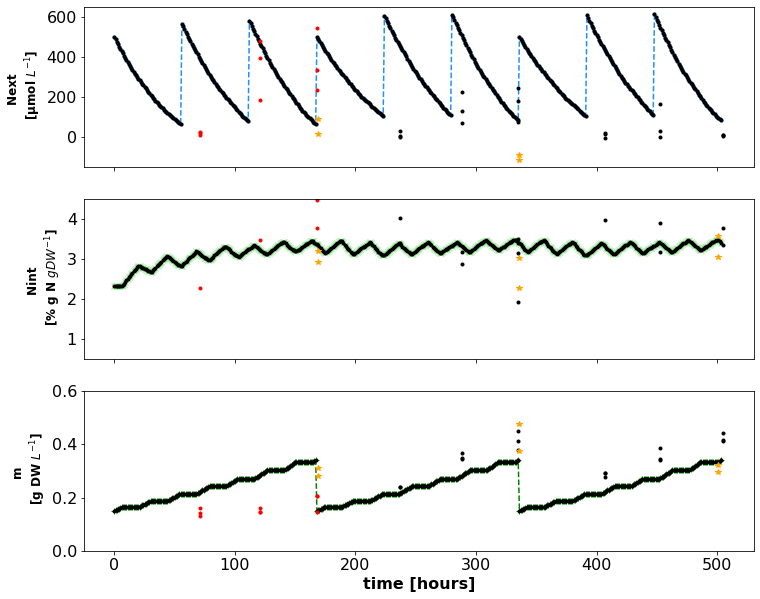

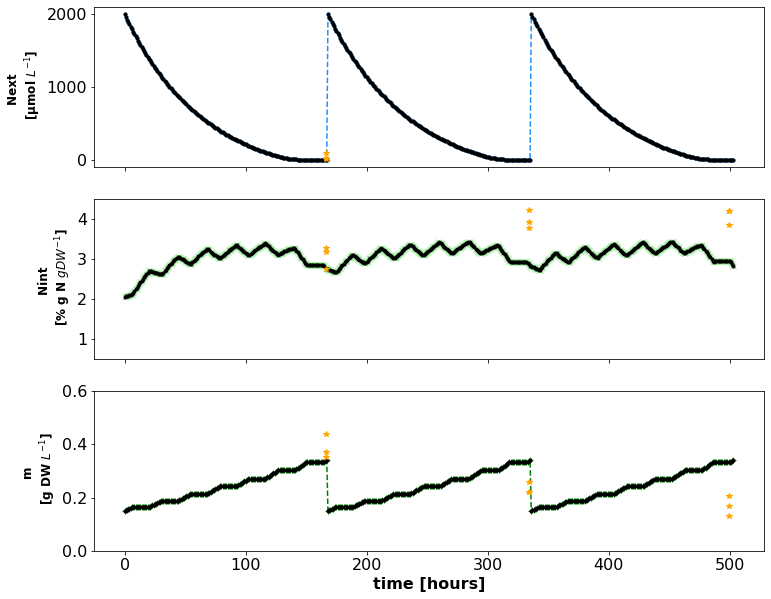

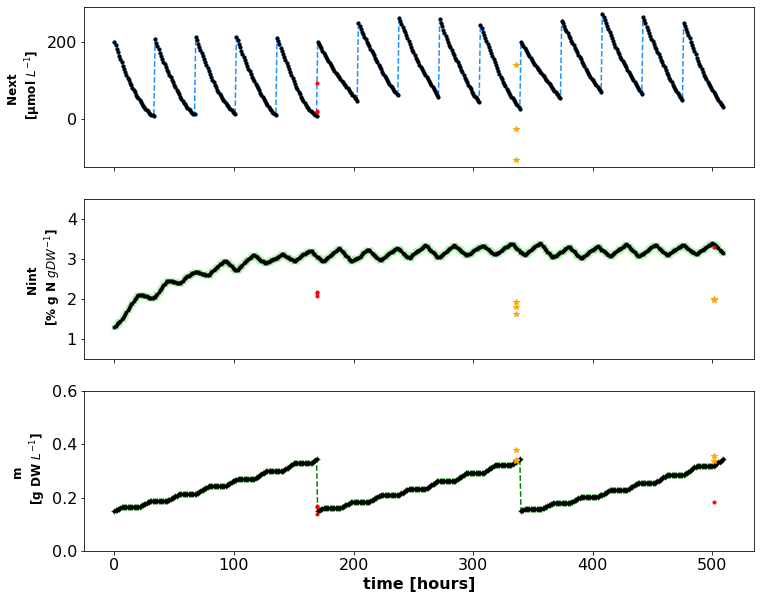

In [11]:
# Visual calibration of high resolution data (data from sporulation events was excluded)

# Calibration data - experiments #3 and #4 (black)
# Validation data - experiments #1, #2 and #5 (orange)
#Ka = 0.15

TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

Temp = 22
#I0 = 80
S = 39 # fix salinity function and S=40


df2_cal = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)]
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation')&(df2.Duration == 168) & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]


for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    mTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['DW']
    mTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['T']
    NintTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['N']
    NintTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['T']
    NextTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['NH4']
    NextTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude / Period / Duration parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    #T1 = '2019,02,14,17,0'
    #T2 = df3Temp['Timei']
    #T2 = T2.tolist()[0]
    #t0 = Time_to_Hours(T1,T2)
    
    # hour = 0 is 1pm (Meiron)
    # in the indoor settings we have to solve for shorter periods, 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the last Amplitude, 
    # m0 to the end of previous solution of ode()
    # 
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the iniital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 then replace the lines above with
    # the following line and then it will also give you a constant solution you had before
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
        t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

        x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)
        

    TModAll.append(TT)
    #Calibration experimental data
    mExpAllTimes_cal.append(mTimeTemp_cal)
    NintExpAllTimes_cal.append(NintTimeTemp_cal)
    NextExpAllTimes_cal.append(NextTimeTemp_cal)
    
    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    #Sporulation experimental data
    if len(mTimeTemp_spor) > 0: #np.empty(mTimeTemp_spor) != True:
        mExpAllTimes_spor.append(mTimeTemp_spor)
        NintExpAllTimes_spor.append(NintTimeTemp_spor)
        NextExpAllTimes_spor.append(NextTimeTemp_spor)
    
    #Validation model data
    #mModAll_val.append(m_model_val)
    #NintModAll_val.append(Nint_model_val)
    #NextModAll_val.append(Next_model_val) 
    
    #plot_result(t_model,Next_model,Nint_model,m_model,Nint=NintTemp,tNint=NintTimeTemp,m=mTemp,tm=mTimeTemp,Next=NextTemp,tNext=NextTimeTemp)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_val,tNint=NintTimeTemp_val,m=mTemp_val,tm=mTimeTemp_val,Next=NextTemp_val,tNext=NextTimeTemp_val)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val )
    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)


Treatment: 1000/1/168
Number of samples:
m: 27 Nint: 19 Next: 26
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration

Treatment: 500/2/168
Number of samples:
m: 66 Nint: 37 Next: 90
3.5
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


84.0
Period
168.0
Duration
252.0
Period
336.0
Duration
420.0
Period

Treatment: 500/3/168
Number of samples:
m: 18 Nint: 12 Next: 18
2.3333333333333335
0.0
Starting point
56.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


112.0
Period
168.0
Duration
224.0
Period
280.0
Period
336.0
Duration
392.0
Period
448.0
Period

Treatment: 2000/1/168
Number of samples:
m: 0 Nint: 0 Next: 0
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration

Treatment: 200/5/168
Number of samples:
m: 0 Nint: 0 Next: 0
1.4
0.0
Starting point
34.0

C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Period
68.0
Period
102.0
Period
136.0
Period
170.0
Duration
204.0
Period
238.0
Period
272.0
Period
306.0
Period
340.0
Duration
374.0
Period
408.0
Period
442.0
Period
476.0
Period


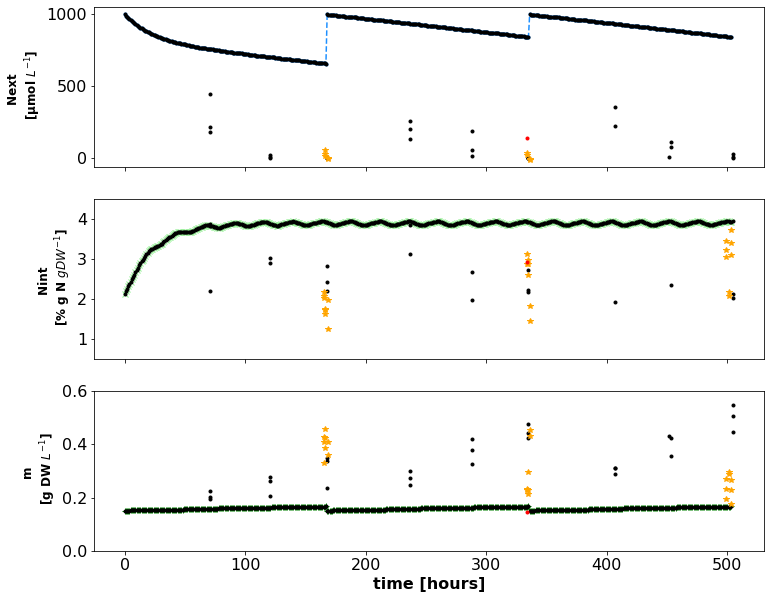

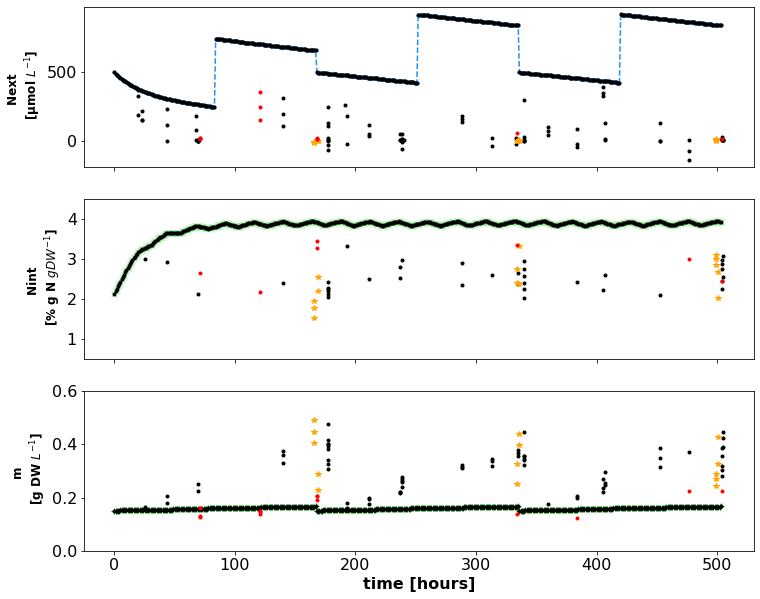

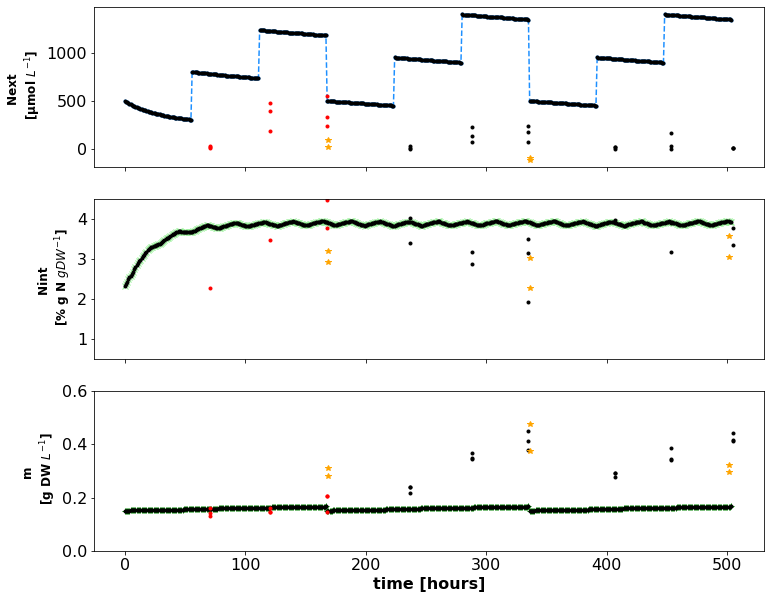

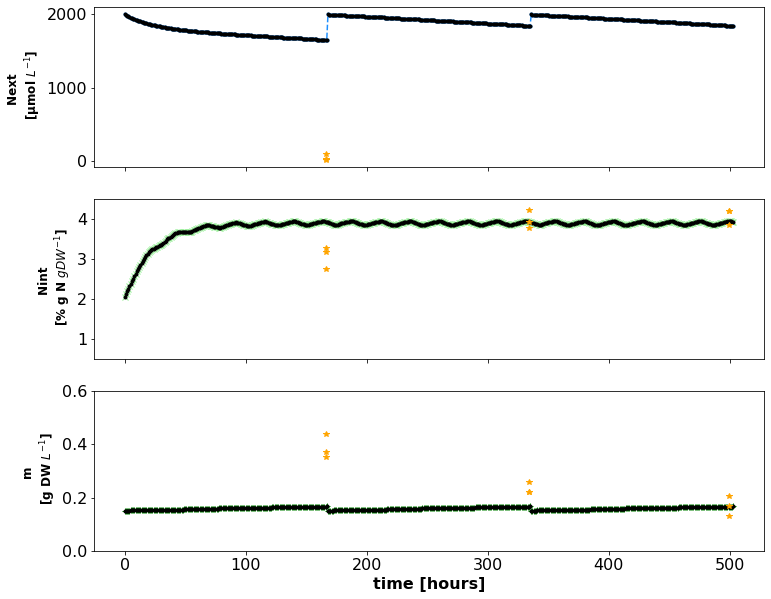

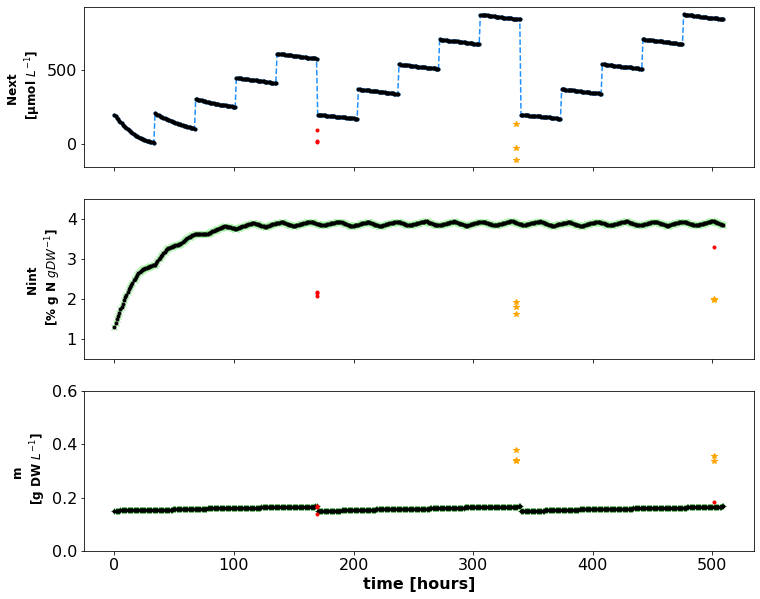

In [39]:
# Same plots but with dNextoutdt = 0

# Calibration data - experiments #3 and #4 (black)
# Validation data - experiments #1, #2 and #5 (orange)
#Ka = 0.15

dNextoutdt = 0

TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

Temp = 22
#I0 = 80
S = 39 # fix salinity function and S=40


df2_cal = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)]
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation')&(df2.Duration == 168) & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]


for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    mTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['DW']
    mTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['T']
    NintTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['N']
    NintTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['T']
    NextTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['NH4']
    NextTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude / Period / Duration parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    #T1 = '2019,02,14,17,0'
    #T2 = df3Temp['Timei']
    #T2 = T2.tolist()[0]
    #t0 = Time_to_Hours(T1,T2)
    
    # hour = 0 is 1pm (Meiron)
    # in the indoor settings we have to solve for shorter periods, 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the last Amplitude, 
    # m0 to the end of previous solution of ode()
    # 
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the iniital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 then replace the lines above with
    # the following line and then it will also give you a constant solution you had before
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
        t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

        x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)
        

    TModAll.append(TT)
    #Calibration experimental data
    mExpAllTimes_cal.append(mTimeTemp_cal)
    NintExpAllTimes_cal.append(NintTimeTemp_cal)
    NextExpAllTimes_cal.append(NextTimeTemp_cal)
    
    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    #Sporulation experimental data
    if len(mTimeTemp_spor) > 0: #np.empty(mTimeTemp_spor) != True:
        mExpAllTimes_spor.append(mTimeTemp_spor)
        NintExpAllTimes_spor.append(NintTimeTemp_spor)
        NextExpAllTimes_spor.append(NextTimeTemp_spor)
    
    #Validation model data
    #mModAll_val.append(m_model_val)
    #NintModAll_val.append(Nint_model_val)
    #NextModAll_val.append(Next_model_val) 
    
    #plot_result(t_model,Next_model,Nint_model,m_model,Nint=NintTemp,tNint=NintTimeTemp,m=mTemp,tm=mTimeTemp,Next=NextTemp,tNext=NextTimeTemp)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_val,tNint=NintTimeTemp_val,m=mTemp_val,tm=mTimeTemp_val,Next=NextTemp_val,tNext=NextTimeTemp_val)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val )
    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)

In [12]:
# calculate time constant of m

TAUm = []
for i in list(range(0,5)):
    a = 0.63*(max(mModAll[i])-0.15)+0.15 # calculate (m(0.63))
    #print(a)
    for j in mModAll[i]:
        m = mModAll[i].tolist()
        if j > a:
            t = m.index(j)
            #print (t)
            break
    l = np.log(a/0.15)
    #print(l)

    tau = -t/l
    TAUm.append(tau)
    #print(tau)
TAUm

[-174.77286629748298,
 -174.7729407625311,
 -174.77300666037362,
 -174.77293339890107,
 -199.0263618232503]

In [13]:
# calculate time constant of Nint

TAUNint = []
for i in list(range(0,5)):
    a = 0.63*(max(NintModAll[i])-2.1)+2.1 # calculate (Nint(0.63))
    #print(a)
    for j in NintModAll[i]:
        Nint = NintModAll[i].tolist()
        if j > a:
            t = Nint.index(j)
            #print (t)
            break
    l = np.log(a/2.1)
    #print(l)

    tau = -t/l
    TAUNint.append(tau)
    #print(tau)
TAUNint

[-124.48251721222056,
 -125.18412041987845,
 -117.80135786906376,
 -121.79069833994056,
 -276.31582371664064]

In [14]:
# calculate time constant of Next

TAUNext = []
NEXT_0 = [1000,500,500,2000,200]
for i in list(range(0,5)):
    a = 0.37*(max(NextModAll[i])) # calculate (Next(0.37))
    #print(a)
    for j in NintModAll[i]:
        Nint = NintModAll[i].tolist()
        if j > a:
            t = Nint.index(j)
            #print (t)
            break
    l = np.log(a/NEXT_0[i])
    #print(l)

    tau = -t/l
    TAUNext.append(tau)
    #print(tau)
TAUNext

[91.5260668139576,
 92.08883032205607,
 114.84776557328291,
 91.5260668139576,
 131.1289434755292]

In [15]:
# Calibration data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

mExpAllTimes_cal_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

0
1
2
3
4


In [16]:
# Calibration data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    mSRE_All.append(mSRE) # All Square Relative Errors
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    NintSRE_All.append(NintSRE) # All Square Relative Errors
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

Treatment: 1000/1/168

m

Number of samples: 27

Sample #91
Measured biomass: 0.201
Modeled biomass: 0.218

Relative Error: 0.079

Sample #91
Measured biomass: 0.261
Modeled biomass: 0.281

Relative Error: 0.073

Sample #92
Measured biomass: 0.225
Modeled biomass: 0.218

Relative Error: 0.031

Sample #92
Measured biomass: 0.276
Modeled biomass: 0.281

Relative Error: 0.019

Sample #93
Measured biomass: 0.195
Modeled biomass: 0.218

Relative Error: 0.106

Sample #93
Measured biomass: 0.204
Modeled biomass: 0.281

Relative Error: 0.275

Sample #91
Measured biomass: 0.336
Modeled biomass: 0.341

Relative Error: 0.014

Sample #92
Measured biomass: 0.348
Modeled biomass: 0.341

Relative Error: 0.021

Sample #93
Measured biomass: 0.234
Modeled biomass: 0.341

Relative Error: 0.313

Sample #101
Measured biomass: 0.246
Modeled biomass: 0.214

Relative Error: 0.149

Sample #101
Measured biomass: 0.327
Modeled biomass: 0.278

Relative Error: 0.175

Sample #102
Measured biomass: 0.3
Modeled bioma

The RMSRE of m in treamtment 2000/1/168 is: nan

end of treatment 2000/1/168


Nint

Number of samples: 0


The RMSRE of Nint in treamtment 2000/1/168 is: nan


Next

Number of samples: 0


The RMSRE of Next in treamtment 2000/1/168 is: nan

Treatment: 200/5/168

m

Number of samples: 0

The RMSRE of m in treamtment 200/5/168 is: nan

end of treatment 200/5/168


Nint

Number of samples: 0


The RMSRE of Nint in treamtment 200/5/168 is: nan


Next

Number of samples: 0


The RMSRE of Next in treamtment 200/5/168 is: nan

End of treatment 200/5/168



C:\Users\meiro\Anaconda3new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\meiro\Anaconda3new\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\meiro\Anaconda3new\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
# Biomass model error of calibration data

mSRE_AllTemp = []
for i in range(len(mSRE_All)):
    for j in range(len(mSRE_All[i])):
        mSRE_AllTemp.append(mSRE_All[i][j])
RMSREm = round((np.mean(mSRE_AllTemp))**0.5,3)
print(RMSREm)
#0.154

0.233


In [18]:
# Nint model error of calibration data

NintSRE_AllTemp = []
for i in range(len(NintSRE_All)):
    for j in range(len(NintSRE_All[i])):
        NintSRE_AllTemp.append(NintSRE_All[i][j])
RMSRENint = round((np.mean(NintSRE_AllTemp))**0.5,3)
print(RMSRENint)
#0.232

0.214


In [19]:
# Next model error of calibration data
NextSRE_AllTemp = []
for i in range(len(NextSRE_All)):
    for j in range(len(NextSRE_All[i])):
        NextSRE_AllTemp.append(NextSRE_All[i][j])
RMSRENext = round((np.mean(NextSRE_AllTemp))**0.5,3)
print(RMSRENext)

53914271308.049


In [20]:
# print errors:

print('\nError of m is: ' + str(RMSREm))
print('\nError of Nint is: ' + str(RMSRENint))


Error of m is: 0.233

Error of Nint is: 0.214


In [21]:
# calibrate by minimum N error

miu = 0.028
losses20 = 0.003
Nintmax = 4.095
Nintcrit = 1.585
dNextoutdt = 0.195
Ks = 25.5
Vmax = 110
KI = 35.2
K0 = 2.39
Ka = 0.17
Smin = 1.6
Sopt = 20.8
Smax = 42.3
Topt = 18.1
Tmax = 34.5




In [22]:
# Calibration data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

mExpAllTimes_cal_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

0
1
2
3
4


In [23]:
# Validation data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

#mExpAllTimes_cal_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

0
1
2
3
4


In [24]:
# Validation data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    mSRE_All.append(mSRE) # All Square Relative Errors
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    NintSRE_All.append(NintSRE) # All Square Relative Errors
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    #df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]
    #print('\nNext\n')
    #print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    #k = 0
    #for j in df2Next.Sample:
    #    Nextexp = df2Next.NH4
    #    if Nextexp.iloc[k] < 0:
    #        Nextexp.iloc[k] = 0
    #    Nextmod = NextModReducedAll[i]
    #    NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
    #    print('Sample #' + str(math.floor(float(j))))
    #    print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
    #    print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
    #    k = k + 1
    #RMSRENext = round((np.mean(NextSRE))**0.5,3)
    #NextSRE_All.append(NextSRE)
    #print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

Treatment: 1000/1/168

m

Number of samples: 23

Sample #1
Measured biomass: 0.408
Modeled biomass: 0.333

Relative Error: 0.225

Sample #2
Measured biomass: 0.426
Modeled biomass: 0.333

Relative Error: 0.279

Sample #3
Measured biomass: 0.33
Modeled biomass: 0.333

Relative Error: 0.009

Sample #11
Measured biomass: 0.294
Modeled biomass: 0.338

Relative Error: 0.13

Sample #12
Measured biomass: 0.213
Modeled biomass: 0.338

Relative Error: 0.37

Sample #13
Measured biomass: 0.228
Modeled biomass: 0.338

Relative Error: 0.325

Sample #21
Measured biomass: 0.267
Modeled biomass: 0.338

Relative Error: 0.21

Sample #22
Measured biomass: 0.174
Modeled biomass: 0.338

Relative Error: 0.485

Sample #23
Measured biomass: 0.228
Modeled biomass: 0.338

Relative Error: 0.325

Sample #31
Measured biomass: 0.423
Modeled biomass: 0.335

Relative Error: 0.264

Sample #32
Measured biomass: 0.387
Modeled biomass: 0.335

Relative Error: 0.157

Sample #33
Measured biomass: 0.456
Modeled biomass: 0.33

In [25]:
# Biomass model error of validation data

mSRE_AllTemp = []
for i in range(len(mSRE_All)):
    for j in range(len(mSRE_All[i])):
        mSRE_AllTemp.append(mSRE_All[i][j])
RMSREm = round((np.mean(mSRE_AllTemp))**0.5,3)
print(RMSREm)

0.267


In [26]:
# Nint model error of validation data

NintSRE_AllTemp = []
for i in range(len(NintSRE_All)):
    for j in range(len(NintSRE_All[i])):
        NintSRE_AllTemp.append(NintSRE_All[i][j])
RMSRENint = round((np.mean(NintSRE_AllTemp))**0.5,3)
print(RMSRENint)

0.317


In [27]:
# Next model error of validation data
NextSRE_AllTemp = []
for i in range(len(NextSRE_All)):
    for j in range(len(NextSRE_All[i])):
        NextSRE_AllTemp.append(NextSRE_All[i][j])
RMSRENext = round((np.mean(NextSRE_AllTemp))**0.5,3)
print(RMSRENext)

nan



Treatment: 1000/1/168
Number of samples:
m: 51 Nint: 43 Next: 40
7.0
0.0
Starting point
168.0
Duration
336.0
Duration

Treatment: 500/2/168
Number of samples:
m: 93 Nint: 58 Next: 120
3.5
0.0
Starting point
84.0
Period
168.0
Duration
252.0
Period
336.0
Duration
420.0
Period

Treatment: 500/3/168
Number of samples:
m: 33 Nint: 23 Next: 31
2.3333333333333335
0.0
Starting point
56.0
Period
112.0
Period
168.0
Duration
224.0
Period
280.0
Period
336.0
Duration
392.0
Period
448.0
Period

Treatment: 2000/1/168
Number of samples:
m: 9 Nint: 9 Next: 9
7.0
0.0
Starting point
168.0
Duration
336.0
Duration

Treatment: 200/5/168
Number of samples:
m: 9 Nint: 9 Next: 6
1.4
0.0
Starting point
34.0
Period
68.0
Period
102.0
Period
136.0
Period
170.0
Duration
204.0
Period
238.0
Period
272.0
Period
306.0
Period
340.0
Duration
374.0
Period
408.0
Period
442.0
Period
476.0
Period


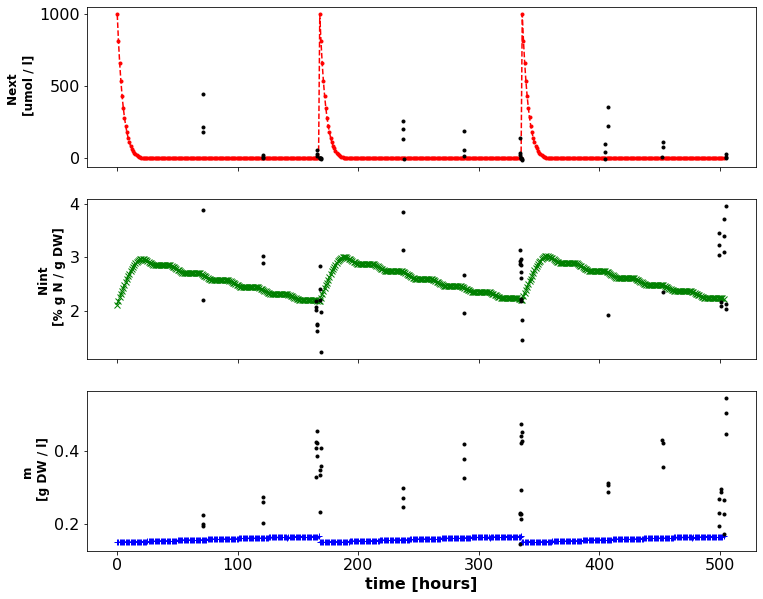

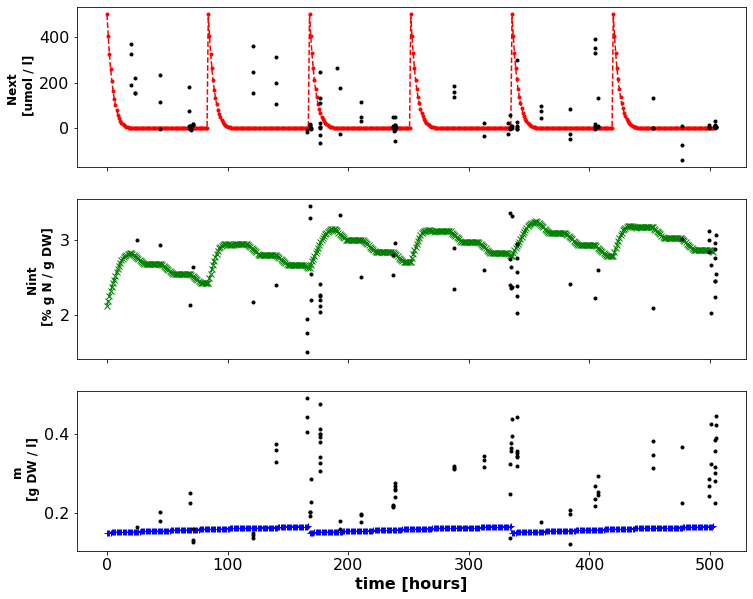

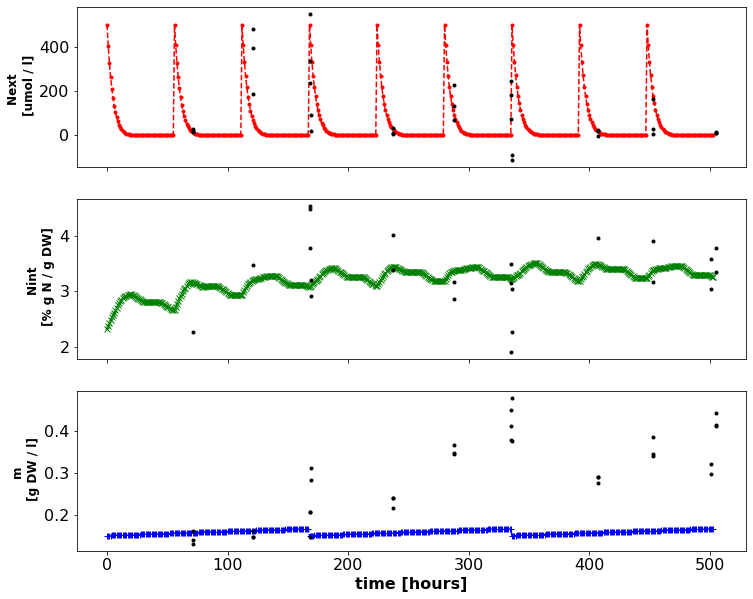

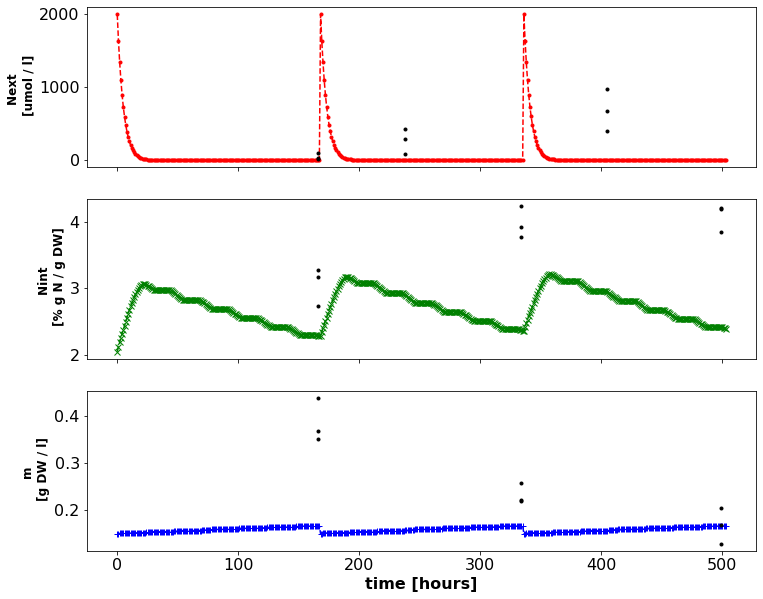

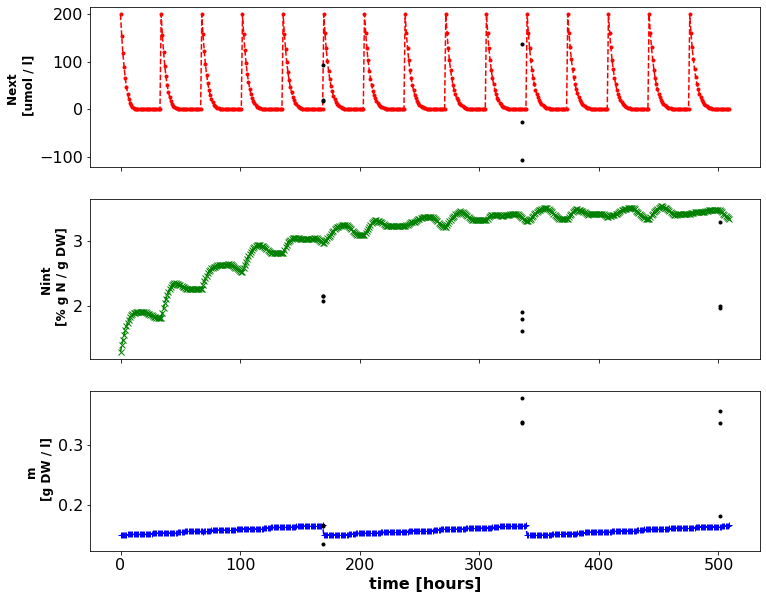

In [28]:
# Plot of all data - including from sporulation events

TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_Full,NintExpAllTimes_Full,NextExpAllTimes_Full = [],[],[]
mModAll_Full,NintModAll_Full,NextModAll_Full = [],[],[]

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

Temp = 22
#I0 = 80
S = 39 # fix salinity function and S=40

df2_ReducedFull = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i')&(df2.Comment != 'Exclude')]

for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_Full = df2_ReducedFull[(df2_ReducedFull.Treatment == i)]
    mTemp_Full = df2Temp_Full[(np.isnan(df2Temp_Full.DW) != True)]['DW']
    mTimeTemp_Full = df2Temp_Full[(np.isnan(df2Temp_Full.DW) != True)]['T']
    NintTemp_Full = df2Temp_Full[(np.isnan(df2Temp_Full.N) != True)]['N']
    NintTimeTemp_Full = df2Temp_Full[(np.isnan(df2Temp_Full.N) != True)]['T']
    NextTemp_Full = df2Temp_Full[(np.isnan(df2Temp_Full.NH4) != True)]['NH4']
    NextTimeTemp_Full = df2Temp_Full[(np.isnan(df2Temp_Full.NH4) != True)]['T']  
    
    print('Number of samples:\nm: ' + str(len(mTimeTemp_Full)) + ' Nint: ' + str(len(NintTimeTemp_Full)) + ' Next: ' + str(len(NextTimeTemp_Full)))
    
    # Amplitude / Period / Duration parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    #T1 = '2019,02,14,17,0'
    #T2 = df3Temp['Timei']
    #T2 = T2.tolist()[0]
    #t0 = Time_to_Hours(T1,T2)
    
    # hour = 0 is 1pm (Meiron)
    # in the indoor settings we have to solve for shorter periods, 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the last Amplitude, 
    # m0 to the end of previous solution of ode()
    # 
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the iniital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 then replace the lines above with
    # the following line and then it will also give you a constant solution you had before
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
        t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

        x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)
    mExpAllTimes_Full.append(mTimeTemp_Full)
    NintExpAllTimes_Full.append(NintTimeTemp_Full)
    NextExpAllTimes_Full.append(NextTimeTemp_Full)
    
    #model data
    mModAll_Full.append(m_model)
    NintModAll_Full.append(Nint_model)
    NextModAll_Full.append(Next_model)
      
    plot_result(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_Full,tNint=NintTimeTemp_Full,m=mTemp_Full,tm=mTimeTemp_Full,Next=NextTemp_Full,tNext=NextTimeTemp_Full)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_val,tNint=NintTimeTemp_val,m=mTemp_val,tm=mTimeTemp_val,Next=NextTemp_val,tNext=NextTimeTemp_val)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val )

In [29]:
# Full data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll_Full[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_Full[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll_Full[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_Full[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll_Full[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_Full[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

0
1
2
3
4


In [30]:
# Full data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_ReducedFull[(np.isnan(df2_ReducedFull.DW) != True)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    mSRE_All.append(mSRE) # All Square Relative Errors
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_ReducedFull[(np.isnan(df2_ReducedFull.N) != True)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    NintSRE_All.append(NintSRE) # All Square Relative Errors
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    df2Next = df2_ReducedFull[(np.isnan(df2_ReducedFull.NH4) != True)&(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

Treatment: 1000/1/168

m

Number of samples: 50

Sample #1
Measured biomass: 0.408
Modeled biomass: 0.166

Relative Error: 1.46

Sample #2
Measured biomass: 0.426
Modeled biomass: 0.166

Relative Error: 1.568

Sample #3
Measured biomass: 0.33
Modeled biomass: 0.166

Relative Error: 0.99

Sample #11
Measured biomass: 0.294
Modeled biomass: 0.166

Relative Error: 0.771

Sample #12
Measured biomass: 0.213
Modeled biomass: 0.166

Relative Error: 0.283

Sample #13
Measured biomass: 0.228
Modeled biomass: 0.166

Relative Error: 0.373

Sample #21
Measured biomass: 0.267
Modeled biomass: 0.166

Relative Error: 0.608

Sample #22
Measured biomass: 0.174
Modeled biomass: 0.166

Relative Error: 0.048

Sample #23
Measured biomass: 0.228
Modeled biomass: 0.166

Relative Error: 0.373

Sample #31
Measured biomass: 0.423
Modeled biomass: 0.166

Relative Error: 1.552

Sample #32
Measured biomass: 0.387
Modeled biomass: 0.166

Relative Error: 1.334

Sample #33
Measured biomass: 0.456
Modeled biomass: 0.1

Sample #131
Measured Next: 0.0
Modeled Next: 0.0

Sample #132
Measured Next: 0.0
Modeled Next: 0.0


The RMSRE of Next in treamtment 1000/1/168 is: 1.395861598671478e+32

Treatment: 500/2/168

m

Number of samples: 80

Sample #37
Measured biomass: 0.405
Modeled biomass: 0.166

Relative Error: 1.443

Sample #38
Measured biomass: 0.444
Modeled biomass: 0.166

Relative Error: 1.678

Sample #39
Measured biomass: 0.492
Modeled biomass: 0.166

Relative Error: 1.968

Sample #47
Measured biomass: 0.249
Modeled biomass: 0.166

Relative Error: 0.502

Sample #49
Measured biomass: 0.324
Modeled biomass: 0.166

Relative Error: 0.954

Sample #57
Measured biomass: 0.288
Modeled biomass: 0.166

Relative Error: 0.737

Sample #58
Measured biomass: 0.27
Modeled biomass: 0.166

Relative Error: 0.628

Sample #59
Measured biomass: 0.243
Modeled biomass: 0.166

Relative Error: 0.465

Sample #61
Measured biomass: 0.165
Modeled biomass: 0.166

Relative Error: 0.005

Sample #61
Measured biomass: 0.18
Modeled bi

C:\Users\meiro\Anaconda3new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Measured Next: 0.0
Modeled Next: 0.0

Sample #39
Measured Next: 0.0
Modeled Next: 0.0

Sample #47
Measured Next: 0.0
Modeled Next: 0.0

Sample #48
Measured Next: 1.457
Modeled Next: 0.0

Sample #49
Measured Next: 0.0
Modeled Next: 0.0

Sample #47
Measured Next: 1.91
Modeled Next: 0.0

Sample #49
Measured Next: 0.0
Modeled Next: 0.0

Sample #57
Measured Next: 9.693
Modeled Next: 0.0

Sample #58
Measured Next: 19.056
Modeled Next: 0.0

Sample #59
Measured Next: 0.0
Modeled Next: 0.0

Sample #57
Measured Next: 1.499
Modeled Next: 0.0

Sample #58
Measured Next: 14.58
Modeled Next: 0.0

Sample #59
Measured Next: 7.188
Modeled Next: 0.0

Sample #61
Measured Next: 0.74
Modeled Next: 0.0

Sample #62
Measured Next: 0.0
Modeled Next: 0.0

Sample #63
Measured Next: 0.0
Modeled Next: 0.0

Sample #64
Measured Next: 0.2
Modeled Next: 0.0

Sample #65
Measured Next: 7.76
Modeled Next: 0.0

Sample #66
Measured Next: 8.598
Modeled Next: 0.0

Sample #67
Measured Next: 189.48
Modeled Next: 0.0

Sample #6

Measured Next: 179.653
Modeled Next: 0.0

Sample #108
Measured Next: 244.267
Modeled Next: 0.0

Sample #109
Measured Next: 75.224
Modeled Next: 0.0

Sample #117
Measured Next: 18.911
Modeled Next: 35.68

Sample #117
Measured Next: 29.642
Modeled Next: 114.735

Sample #118
Measured Next: 21.413
Modeled Next: 35.68

Sample #118
Measured Next: 3.058
Modeled Next: 114.735

Sample #119
Measured Next: 0.0
Modeled Next: 35.68

Sample #119
Measured Next: 165.092
Modeled Next: 114.735

Sample #117
Measured Next: 11.708
Modeled Next: 0.0

Sample #118
Measured Next: 8.868
Modeled Next: 0.0

Sample #119
Measured Next: 13.232
Modeled Next: 0.0

Sample #125
Measured Next: 18.459
Modeled Next: 22.325

Sample #126
Measured Next: 90.379
Modeled Next: 219.287

Sample #135
Measured Next: 0.0
Modeled Next: 22.325

Sample #136
Measured Next: 0.0
Modeled Next: 219.287


The RMSRE of Next in treamtment 500/3/168 is: 11476256.535

Treatment: 2000/1/168

m

Number of samples: 9

Sample #34
Measured biomass: 0.

In [31]:
# Biomass model error of validation data

mSRE_AllTemp = []
for i in range(len(mSRE_All)):
    for j in range(len(mSRE_All[i])):
        mSRE_AllTemp.append(mSRE_All[i][j])
RMSREm = round((np.mean(mSRE_AllTemp))**0.5,3)
print(RMSREm)

1.095


In [32]:
# Nint model error of validation data

NintSRE_AllTemp = []
for i in range(len(NintSRE_All)):
    for j in range(len(NintSRE_All[i])):
        NintSRE_AllTemp.append(NintSRE_All[i][j])
RMSRENint = round((np.mean(NintSRE_AllTemp))**0.5,3)
print(RMSRENint)

0.291


In [33]:
# Next model error of validation data
NextSRE_AllTemp = []
for i in range(len(NextSRE_All)):
    for j in range(len(NextSRE_All[i])):
        NextSRE_AllTemp.append(NextSRE_All[i][j])
RMSRENext = round((np.mean(NextSRE_AllTemp))**0.5,3)
print(RMSRENext)

6.461589989853489e+31


In [34]:
# II. Make a filtered array including only times of empiric measurement (remove from array results from times in which data was not measured)
# III. Add relevant columns from df2_temp and the model results to a new df_combined

In [35]:
df2_cal = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)]
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Duration == 168)]

In [36]:
print(rp.summary_cont(df2_cal['DW']))
print(rp.summary_cont(df2_cal['N']))
print(rp.summary_cont(df2_cal['DW'].groupby(df2_cal['Treatment'])))
print(rp.summary_cont(df2_cal['N'].groupby(df2_cal['Treatment'])))



  Variable      N   Mean      SD     SE  95% Conf.  Interval
0       DW  111.0  0.319  0.0847  0.008      0.303    0.3349


  Variable     N    Mean      SD      SE  95% Conf.  Interval
0        N  68.0  2.7167  0.5645  0.0685     2.5801    2.8533


             N    Mean      SD      SE  95% Conf.  Interval
Treatment                                                  
1000/1/168  27  0.3400  0.0986  0.0190     0.3010    0.3790
500/2/168   66  0.3036  0.0796  0.0098     0.2841    0.3232
500/3/168   18  0.3437  0.0712  0.0168     0.3083    0.3790


             N    Mean      SD      SE  95% Conf.  Interval
Treatment                                                  
1000/1/168  19  2.6646  0.6547  0.1502     2.3491    2.9802
500/2/168   37  2.5391  0.3301  0.0543     2.4290    2.6491
500/3/168   12  3.3468  0.5822  0.1681     2.9769    3.7167


In [37]:
print(rp.summary_cont(df2_val['DW']))
print(rp.summary_cont(df2_val['N']))
print(rp.summary_cont(df2_val['DW'].groupby(df2_val['Treatment'])))
print(rp.summary_cont(df2_val['N'].groupby(df2_val['Treatment'])))



  Variable     N    Mean      SD      SE  95% Conf.  Interval
0       DW  57.0  0.3194  0.0892  0.0118     0.2958    0.3431


  Variable     N    Mean      SD      SE  95% Conf.  Interval
0        N  57.0  2.6627  0.7736  0.1025     2.4574    2.8679


             N    Mean      SD      SE  95% Conf.  Interval
Treatment                                                  
1000/1/168  23  0.3141  0.0924  0.0193     0.2741    0.3541
200/5/168    5  0.3492  0.0183  0.0082     0.3265    0.3719
2000/1/168   9  0.2620  0.1023  0.0341     0.1834    0.3406
500/2/168   14  0.3439  0.0873  0.0233     0.2935    0.3943
500/3/168    6  0.3440  0.0725  0.0296     0.2680    0.4200


             N    Mean      SD      SE  95% Conf.  Interval
Treatment                                                  
1000/1/168  23  2.4595  0.7202  0.1502     2.1480    2.7709
200/5/168    5  1.8618  0.1577  0.0705     1.6660    2.0576
2000/1/168   9  3.7062  0.5282  0.1761     3.3002    4.1123
500/2/168   14  2.4631  

In [38]:
print(rp.summary_cont(df2_spor['DW']))
print(rp.summary_cont(df2_spor['N']))
print(rp.summary_cont(df2_spor['DW'].groupby(df2_spor['Treatment'])))
print(rp.summary_cont(df2_spor['N'].groupby(df2_spor['Treatment'])))



  Variable     N    Mean      SD     SE  95% Conf.  Interval
0       DW  27.0  0.1634  0.0311  0.006     0.1511    0.1757


  Variable     N    Mean     SD      SE  95% Conf.  Interval
0        N  17.0  3.0318  0.778  0.1887     2.6318    3.4318


             N    Mean      SD      SE  95% Conf.  Interval
Treatment                                                  
1000/1/168   1  0.1470     NaN     NaN        NaN       NaN
200/5/168    4  0.1631  0.0194  0.0097     0.1322    0.1940
500/2/168   13  0.1662  0.0382  0.0106     0.1431    0.1892
500/3/168    9  0.1613  0.0275  0.0092     0.1402    0.1825


            N    Mean      SD      SE  95% Conf.  Interval
Treatment                                                 
1000/1/168  1  2.9349     NaN     NaN        NaN       NaN
200/5/168   4  2.4251  0.5828  0.2914     1.4977    3.3525
500/2/168   7  2.9114  0.4902  0.1853     2.4580    3.3648
500/3/168   5  3.7052  0.9182  0.4106     2.5651    4.8453


C:\Users\meiro\Anaconda3new\lib\site-packages\scipy\stats\_distn_infrastructure.py:1996: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
C:\Users\meiro\Anaconda3new\lib\site-packages\scipy\stats\_distn_infrastructure.py:1996: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
